In [1]:
import itertools
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline

# Index
* [Load the data](#Load-the-data)
* [Answer question 1](#Answer-question-1)
* [Answer question 2](#Answer-question-2)
* [Answer question 3](#Answer-question-3)
    * [Prepare features](#Prepare-features)
    * [Reduce dimensions and visualize](#Reduce-dimensions-and-visualize)
    * [Kmeans to cluster](#Kmeans-to-cluster)
    * [Check the result](#Check-the-result)

## Load the data

In [3]:
holders = pd.read_csv('cc_info.csv',index_col='credit_card')
holders.rename(columns={'credit_card_limit':'credit_limit'},inplace=True)

In [4]:
transactions = pd.read_csv('transactions.csv')
transactions['date'] = pd.to_datetime(transactions.date)
transactions.rename(columns={'transaction_dollar_amount':'amount'},inplace=True)

## Answer question 1
Your boss wants to identify those users that in your dataset never went above the monthly credit card limit (calendar month). The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [5]:
transactions.date.dt.year.value_counts()

2015    294588
Name: date, dtype: int64

First, we need to calculate each user's monthly spent.

In [6]:
def monthly_spent_byuser(df):
    # I have checked the data already, all transactions happen in year 2015
    # so I can just group by month
    return df.groupby(df.date.dt.month)['amount'].agg('sum')

In [7]:
# first group by 'credit_card' (i.e., by user)
# then sum up all spent by month
card_month_spents = transactions.groupby("credit_card").apply(monthly_spent_byuser).unstack(fill_value=0)

In [8]:
# join with 'credit_limit' to simplify the comparison
card_month_spents = card_month_spents.join(holders.credit_limit)
card_month_spents.head()

date,7,8,9,10,credit_limit
credit_card,,,,,
1003715054175576,162.56,8441.51,11281.56,8954.21,20000
1013870087888817,281.43,11981.15,12461.96,12090.34,15000
1023820165155391,943.26,22741.20,18108.12,19259.98,28000
1073931538936472,220.07,2991.05,2557.12,1638.03,10000
1077622576192810,0.00,634.61,551.28,604.84,10000


Then, we check whether each user has exceed his credit limit before.

In [9]:
n_months = card_month_spents.shape[1]-1
def is_never_above_limit(s):
    limit = s.loc['credit_limit']
    return (s.iloc[0:n_months] <= limit).all()

is_user_never_exceed_limit = card_month_spents.apply(is_never_above_limit,axis=1)

users_never_exceed_limit = card_month_spents.loc[is_user_never_exceed_limit ,:].index

In [10]:
users_never_exceed_limit

Int64Index([1003715054175576, 1013870087888817, 1023820165155391,
            1073931538936472, 1077622576192810, 1087468642191606,
            1089479586475600, 1101164752077181, 1107936587129946,
            1126571863414211,
            ...
            9854872265114976, 9855217884613002, 9867492085978660,
            9884182241594028, 9938969980242308, 9946917923319410,
            9958678964376192, 9961694231875562, 9981251982982618,
            9986135779184360],
           dtype='int64', name=u'credit_card', length=862)

In [11]:
with open("users_never_exceed_limit.txt","wt") as outf:
    for cardno in users_never_exceed_limit:
        outf.write('{}\n'.format(cardno))

## Answer question 2
On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notiﬁed about that.We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [12]:
class MonthSpentMonitor(object):

    def __init__(self,credit_limits):
        """
        card_limits is a dictionary
        key=card number, value=credit limit
        """
        self.total_spent = defaultdict(float)
        self.credit_limits = credit_limits

    def reset(self):
        self.total_spent.clear()

    def count(self,daily_transaction):
        """
        daily_transaction: a dict
        key=card number, value=amount
        """
        for cardno,amount in daily_transaction:
            self.total_spent[cardno] += amount

        # assume 'credit_limits' always can find the cardno
        # otherwise, raise KeyError, which is a good indicator showing something is wrong
        return [ cardno for cardno,total in self.total_spent.viewitems() if total > self.credit_limits[cardno]]

<span style='color:red;'>Due to time limitation, and since the question doesn't provide enough information about the requirement (e.g. input format), I just provide above codes. if given enough time and more clear API specification, I will write some test code to test/demonstrate above codes.</span>

### Answer question 3
Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

### Prepare features
I think there are two factors which impact a transaction is fraud or not:
1. if the transaction violates that user's consumption habit. For example, if a user spend less then 200 each transaction most of the time, then a transaction more than 1000 will be highly suspicious.
2. if user spend the money far from his home, although it is possible due to traveling, but it's still very suspicious.

Although the data provide each transaction's geometric information and card holder's home, <span style='color:red'>unfortunately, due to time limits, I cannot relate each transation's 'Long' and 'Lat' with that card holder's home address</span>. so I have to drop the second factor listed above, and <span style='color:orange;font-size:1.5em'>only make features from user's previous comsumption history.</span>

<span style='color:red;font-weight:bold'>if given more time, I would use some Map Web API to map Long/Lat to address, and compare with card-holder's address, which will be a very useful feature to detect credit fraud.</span>

In [13]:
def statistics_by_card(s):
    ps = [25, 50, 75]
    d = np.percentile(s,ps)
    return pd.Series(d,index=['{}%'.format(p) for p in ps])

tran_statistics = transactions.groupby('credit_card')['amount'].apply(statistics_by_card).unstack()

In [14]:
tran_statistics.head()

,25%,50%,75%
credit_card,,,
1003715054175576,59.01,93.73,124.63
1013870087888817,58.09,87.67,128.02
1023820165155391,55.43,85.78,122.83
1073931538936472,108.08,147.19,194.83
1077622576192810,122.93,148.18,160.11


then merge the 'transaction', 'previous consumption history' and 'credit limit' together, put all useful information about the transaction in one DataFrame

In [15]:
# merge 'transaction' with 'previous consumption statistics'
temp = pd.merge(transactions,tran_statistics,how='left',left_on='credit_card',right_index=True)

# merge with credit limit
transactions = pd.merge(temp,holders.loc[:,['credit_limit']],how='left',left_on='credit_card',right_index=True)

In [16]:
transactions.tail()

,credit_card,date,amount,Long,Lat,25%,50%,75%,credit_limit
294583,9999757432802760,2015-09-10 19:43:33,127.23,-82.360952,32.978497,83.74,130.94,177.905,6000
294584,9999757432802760,2015-08-06 21:00:13,84.90,-82.322721,33.061071,83.74,130.94,177.905,6000
294585,9999757432802760,2015-09-22 16:15:47,77.54,-82.442130,32.949983,83.74,130.94,177.905,6000
294586,9999757432802760,2015-08-27 18:08:24,144.05,-82.398587,32.976162,83.74,130.94,177.905,6000
294587,9999757432802760,2015-08-22 00:14:52,154.36,-82.389680,33.068351,83.74,130.94,177.905,6000


In [17]:
# save it for later use
transactions.to_csv('extend_transactions.csv',index=False)

### Reduce dimensions and visualize

we only care about current amount and previous consumption history, so we can keep those useful features

In [18]:
X = transactions.loc[:,['amount','25%','50%','75%','credit_limit']]

In [19]:
X.describe()

,amount,25%,50%,75%,credit_limit
count,294588.000000,294588.000000,294588.000000,294588.000000,294588.000000
mean,86.008036,43.265113,69.081697,97.282645,15502.053716
std,124.655954,21.471896,35.160028,49.919646,7956.291556
min,0.010000,6.150000,7.320000,9.120000,2000.000000
25%,29.970000,27.960000,43.590000,60.812500,10000.000000
50%,58.470000,40.595000,65.190000,91.832500,15000.000000
75%,100.400000,56.215000,89.710000,127.345000,20000.000000
max,999.970000,137.690000,222.290000,318.730000,55000.000000


then I want to reduce X to 2D, and visualize it to get some hint. However, <span style='color:orange'>since credit_limit has much higher variance, I need to scale each feature to unit variance before applying PCA</span>, otherwise, the principle components will be highly aligned with 'credit_limit' which doesn't provide useful information.

In [20]:
X = scale(X)

Use PCA to reduce feature matrix to 2D

In [21]:
pca = PCA(n_components=2)
X2d = pca.fit_transform(X)
X2d = pd.DataFrame(X2d,columns=['pc1','pc2'])

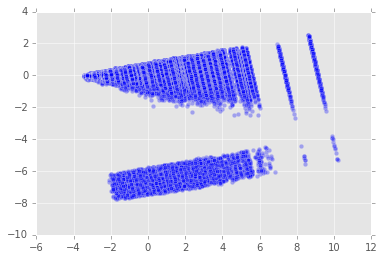

In [22]:
plt.scatter(X2d.pc1,X2d.pc2,alpha=0.3)

### Kmeans to cluster

above plot shows a good sign, that is, the data is well seperated. also above plot give me some hint, may be the data can be grouped into 6 clusters.

then I use Kmeans algorithm to perform the clustering.

In [23]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters,n_jobs=-1)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [24]:
X2d['label'] = kmeans.labels_
print X2d.label.value_counts()

0    107653
4     73544
2     49098
5     33075
1     25782
3      5436
Name: label, dtype: int64


above result also show a good sign, cluster 3 has apparently fewer transcations compared with others. This makes senses, because fraud activity, isn't that normal.

then I plot the clusters in 2D, to check their distribution.

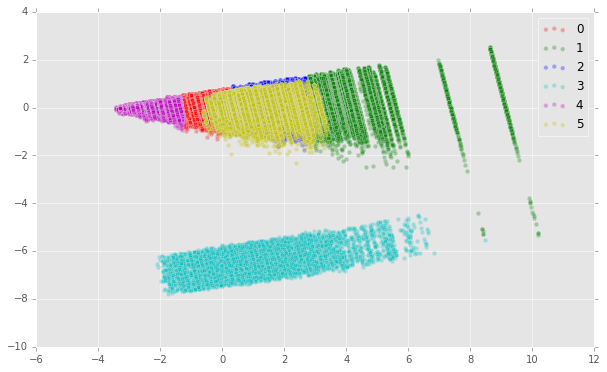

In [25]:
colors = itertools.cycle( ['r','g','b','c','m','y','k'] )

plt.rc('figure',figsize=(10,6))
for label in  xrange(n_clusters) :
    temp = X2d.loc[X2d.label == label,:]
    plt.scatter(temp.pc1,temp.pc2,c=next(colors),label=label,alpha=0.3)

plt.legend(loc='best')

### Check the result
the cyan points represents the suspicious transactions. Let's pick those transactions out, and check whether they make sense or not.

In [26]:
suspect = transactions.loc[X2d.label==3,['credit_card','amount','25%','50%','75%','credit_limit','date']]
suspect.to_csv('suspect.csv',index=False)

In [37]:
suspect.sample(10)

,credit_card,amount,25%,50%,75%,credit_limit,date
242591,8221913653327075,964.52,62.1100,98.810,137.600,25000,2015-08-14 22:36:44
12699,1337293370722685,876.34,43.7300,62.040,89.040,8000,2015-09-13 19:09:16
167445,5915891114492596,820.79,39.0850,62.820,89.610,10000,2015-09-05 21:44:42
4259,1144894232607400,865.64,73.0025,118.775,167.115,35000,2015-09-06 20:21:16
77851,3457862814915595,869.92,41.8125,64.090,90.065,20000,2015-10-04 01:18:37
120751,4616880410668126,912.82,18.1850,27.860,38.040,10000,2015-10-02 21:57:59
75370,3370960377586437,864.94,50.8900,72.930,107.070,10000,2015-10-11 01:34:20
232799,7916370876622524,802.32,70.4950,107.275,153.975,25000,2015-09-07 18:40:44
90297,3801374660832282,984.00,60.7700,103.230,142.160,20000,2015-09-19 21:03:29
189030,6631838888901006,946.57,47.9400,82.700,107.510,8000,2015-09-12 03:41:18


open 'suspect.csv' or see the randomly sampled suspicious transactions list above, we can find <span style='color:orange;font-weight:bold;font-size:1.5em'>their amount is much higher than that user's 75th percentile in his previous consumption history.</span>

for example, in 12697-th transaction, that user's 75th percentile is 89.04, then suddenly it comes a transaction with 977.38, which is very suspicious and need further investigation. 

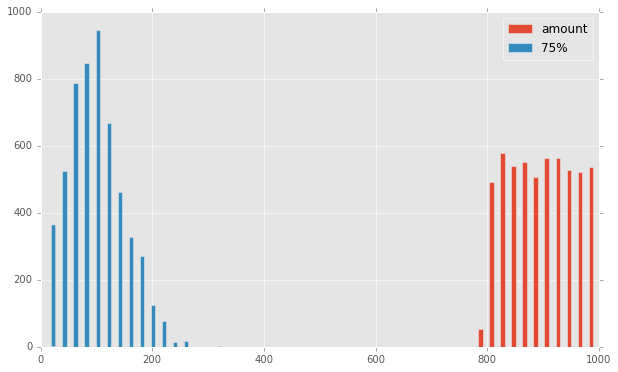

In [36]:
labels = ["amount",'75%']
plt.hist(suspect.loc[:,labels].values,bins=50,label=labels)
plt.legend(loc='best')

histogram of the "consumption amount" and that user's 75th percentile of consumption records, also shows, <span style='color:orange;font-weight:bold;font-size:1.5em'>selected transaction has 'amount' much higher than '75th percentile', which is very suspicious and worth further investigation.</span>